# HW #2 Simple Spread Trading
[FINM 33150] Regression Analysis and Quantitative Trading Strategies\
Winter 2022 | Professor Brian Boonstra

_**Due:** Thursday, January 27th, at 11:00pm\
**Name:** Ashley Tsoi (atsoi, Student ID: 12286230)_

### 1. Fetch and clean data

#### 1-1. Import packages

In [1]:
import quandl
import json
import pandas as pd
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import math
import numpy as np
import datetime as dt
import functools
from itertools import permutations

# let plot display in the notebook instead of in a different window
%matplotlib inline 
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [21, 8]

#### 1-2. Define the functions to fetch data from Quandl

**1-2-1. Get my personal keys** from ../data/APIs.json

In [2]:
f = open('../data/APIs.json')
APIs = json.load(f)
f.close()

**1-2-2. Define date-format helper function**

In [3]:
def assertCorrectDateFormat(date_text):
    try:
        dt.datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect date format, should be YYYY-MM-DD")

**1-2-3. Define function** to retrieve raw data from Quandl

**Documentation:**
```
https://data.nasdaq.com/databases/EOD/usage/quickstart/python
```

In [4]:
# Define function that retrieves data from Quandl
def getQuandlEODData(secs,start_date,end_date):
    # Get one security (sec)'s data fom Quandl using quandl.get_table
    # NOTE: missing data for the inputted date will NOT return a row.

    # INPUT         | DATA TYPE                 | DESCRIPTION
    # sec           | string / list of string   | security name(s)
    # start_date    | string (YYYY-MM-DD)       | start date of data
    # end_date      | string (YYYY-MM-DD)       | end date of data (same as or after start_date)
    
    print("Quandl | START | Retriving Quandl data for securities: \n",secs)
    
    # Retrieve data using quandl.get_table
    quandl.ApiConfig.api_key = APIs['Quandl']
    data = quandl.get_table('QUOTEMEDIA/PRICES',
                            ticker = secs, 
                            date = {'gte':start_date, 'lte':end_date})

    print("Quandl | DONE  | Returning {:d} dates of data for {}.\n".format(len(data),secs))
    return data
    
@functools.lru_cache(maxsize=16) # Cache the function output
def getSpreadData(secs,start_date,end_date,N_window=15):

    # Input validation
    assert len(secs)==2 # secs must be a pair to calculate spread
    assertCorrectDateFormat(start_date)
    assertCorrectDateFormat(end_date)
    assert end_date >= start_date

    # Get Quandl Data
    if isinstance(secs, tuple): secs=list((secs))
    data = pd.DataFrame()
    for sec in secs:
        quandlData = getQuandlEODData(sec,start_date,end_date)[['date','adj_close','adj_volume']].set_index('date').sort_index(ascending=True)
        data[sec+'_adj_close'] = quandlData['adj_close']
        data[sec+'_N_t'] = (quandlData['adj_close']*quandlData['adj_volume']).rolling(N_window).median()

    return data

@functools.lru_cache(maxsize=16) # Cache the function output
def getFFData(start_date,end_date):

    ff = pd.read_csv('../data/F-F_Research_Data_Factors_daily.CSV').rename(columns={'Unnamed: 0':'date'})
    ff['date'] = ff['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    ff = ff.set_index('date')[start_date:end_date]
    
    return ff


#### 1-3. Fetch cleaned spread data using functions above

Last 2 unique digits of my student ID: 3, 0

**Securities:**
```
Pair #0: FCOM VOX
```

**Securities Description:**
```
FCOM - Fidelity MSCI Communication Services Index ETF
VOX - Vanguard Communication Services ETF
```

**Dates:**
```
December 2, 2019 - December 31, 2021
```

In [5]:
# # test out the function "getSpreadData"
# secs,start_date,end_date = ("FCOM","VOX"),"2019-12-02","2021-12-31"
# df = getSpreadData(secs,start_date,end_date)
# df[15:25]

In [6]:
@functools.lru_cache(maxsize=16) # Cache the function output
def spreadTradeSimulation(secs,start_date,end_date,N_window=15,M=10,j=None,g=None,s=-0.5,K=None):
    
    # print("========================================")
    
    spread = getSpreadData(secs,start_date,end_date,N_window).dropna()
    
    if K==None:
        # set K to the maximum of N_t over the data period, times two
        N_t_cols = spread.columns[spread.columns.str.endswith('_N_t')]
        K = int(2*max(spread[N_t_cols].max()))+1
    
    tradeSim = spread[spread.columns[spread.columns.str.endswith('_adj_close')]] # initalize trade simulation table # initalize trade simulation table
    
    for sec in secs:
        tradeSim[sec+'_M_day_cumret'] = (tradeSim[sec+'_adj_close'].pct_change()+1).rolling(M).apply(np.prod,raw=True)-1
    tradeSim['cumret_spread'] = tradeSim[secs[0]+'_M_day_cumret']-tradeSim[secs[1]+'_M_day_cumret']

    if j==None or g==None:
        maxMagnitude = (max(abs(tradeSim['cumret_spread'].max()),abs(tradeSim['cumret_spread'].min())))
        j = 0.1*maxMagnitude
        g = 0.4*maxMagnitude
    
    print("trade  | START | K (initial capital)={}, M={}, j={:.5f}, g={:.5f}, s={:.3f}.\n".format(K,M,j,g,s))
    # print("trade  |       | Trading on {}-day cumulative return spread (X-Y) for X={}, Y={}.\n".format(M,secs[0],secs[1]))
    
    tradeSim = tradeSim[max(N_window,M):] # remove the NaN rows
    # print("trade  |       | Trade period: {} - {} ({} trading days total).\n".format(tradeSim.index[0].strftime("%Y-%m-%d"),tradeSim.index[-1].strftime("%Y-%m-%d"),len(tradeSim)))

    tradeSim['quantity'] = [int(min(row[secs[0]+'_N_t'],row[secs[1]+'_N_t'])/100) for i,row in spread[max(N_window,M):].iterrows()]

    months = tradeSim.index.to_period('M')
    endOfMonths = tradeSim.index[[months[n]!=months[n+1] for n in range(len(months)-1)]+[True]] # set last period to "True" as well to close out position

    # Initiate columns
    positions, prev_position = [0] , 0
    signals = [0]
    position_quantities = [0]
    secX_position_values, secY_position_values = [0], [0]
    position_values = [0]
    K_balances = [K]
    total_values = [K]
    gross_cash = 0
    stop_loss_limits, stop_loss_triggers = [], []
    PnL_daily_list, PnL_cumulative_list = [], []
    for i,row in tradeSim.iterrows(): # current columns: adj_close for both securities, spread, quantities to buy

        # Signals and positions ()
        if i in endOfMonths:
            position = 0
        
        else:
            currRetSpread = row['cumret_spread']
            dir = 1 if (currRetSpread>=0) else -1
            size = dir*currRetSpread # the return spread in absolute terms

            if size>g:
                position = -1*dir
            elif size<j: # around 0
                position = 0
            else: # in between j and g
                position = prev_position if ((prev_position!=dir) and (prev_position!=0)) else 0 # follow the previous position if the side is the same
          
        signal = int(position-prev_position) # buy/sell signal = change of position

        # Calculate present position value (but don't append to list yet since it may hit stop-loss limit)
        if signal: # if there's a new signal
            position_quantity = position*row['quantity'] # quantity = new position's quantity

        else: # if no signal, position quantity = previous position quantity (unless stop-loss limit is triggered later)
            position_quantity = position_quantities[-1]

        # Security buy amounts (but don't append to list yet since it may hit stop-loss limit)
        secX_position_value = position_quantity*row[secs[0]+'_adj_close']
        secY_position_value = -1*position_quantity*row[secs[1]+'_adj_close']
        position_value = secX_position_value + secY_position_value
        
        # Cash balances and total values (if doesn't hit stop-loss limit)
        K_balance = K_balances[-1] - position_value
        total_value = position_value + K_balance
        total_value_delta = total_value-total_values[-1]

        # Stop loss
        if signal: # update gross_cash if entering a new position 
            if position: 
                gross_cash = abs(secX_position_value) + abs(secY_position_value)
            else:
                gross_cash = 0 # reset gross_cash back to 0 if a position is exited/covered

        stop_loss_limit = s*gross_cash if gross_cash!=0 else math.nan
        stop_loss_trigger = total_value_delta < stop_loss_limit
        
        if stop_loss_trigger: 
            # "undo" the transaction
            position = 0 # change position to 0
            signal = int(0-positions[-1])
            
            position_quantity, position_value = 0, 0
            secX_position_value, secY_position_value = 0, 0

            K_balance = K_balances[-1]
            total_value = K_balance

        # PnLs (daily and cumulative)
        PnL_daily = total_value_delta/total_values[-1]
        PnL_cumulative = total_value/K - 1

        # update prev_position for next calculation
        prev_position = position
        
        # Append new variables into lists
        positions.append(position)
        signals.append(signal)
        position_quantities.append(position_quantity)
        secX_position_values.append(secX_position_value)
        secY_position_values.append(secY_position_value)
        position_values.append(position_value)
        K_balances.append(K_balance)
        total_values.append(total_value)
        stop_loss_limits.append(stop_loss_limit)
        stop_loss_triggers.append(stop_loss_trigger)
        PnL_daily_list.append(PnL_daily)
        PnL_cumulative_list.append(PnL_cumulative)

    # Save the data in tradeSim table
    tradeSim['signal'] = signals[1:]
    tradeSim['position'] = positions[1:]
    tradeSim['position_quantity'] = position_quantities[1:]
    tradeSim[secs[0]+'_position_value'] = secX_position_values[1:]
    tradeSim[secs[1]+'_position_value'] = secY_position_values[1:]
    tradeSim['position_value'] = position_values[1:]
    tradeSim['K'] = K_balances[1:]
    tradeSim['total_value'] = total_values[1:]
    tradeSim['stop_loss_limit'] = stop_loss_limits
    tradeSim['stop_loss_trigger'] = stop_loss_triggers
    tradeSim['PnL_daily'] = PnL_daily_list
    tradeSim['PnL_cumulative'] = PnL_cumulative_list
    
    # print("trade  | DONE  | \n")

    # keep a record of params
    summary = {'data':  ['security_X','security_Y','start_date','end_date','N_window','M','j','g','s','K','final_value','PnL_daily_max','PnL_cumulative'],
               'value': [secs[0],secs[1],start_date,end_date,N_window,M,j,g,s,K,total_values[-1],max(PnL_daily_list),PnL_cumulative_list[-1]]
    }
    
    summary_df = pd.DataFrame(summary).set_index('data')
        
    return summary_df,tradeSim


def plotTradeSim(summary,tradeSim):

    plt.clf() # clear previous plots

    j = summary.loc['j'].value
    g = summary.loc['g'].value

    tp = plt

    tp.title('Cumulative Return Spread and Trades')

    tp.plot(tradeSim['cumret_spread'], label='cumulative return spread')
    
    tp.plot(tradeSim['cumret_spread'][tradeSim['signal']>1], color='green', marker='o', markersize=6, linestyle='none')
    tp.plot(tradeSim['cumret_spread'][tradeSim['signal']==1], color='green', marker='o', markersize=4, linestyle='none', label='buy signal')
    tp.plot(tradeSim['cumret_spread'][tradeSim['signal']==-1], color='red', marker='o', markersize=4, linestyle='none', label='sell signal')
    tp.plot(tradeSim['cumret_spread'][tradeSim['signal']<-1], color='red', marker='o', markersize=6, linestyle='none')
    
    tp.plot(tradeSim['cumret_spread'][tradeSim['stop_loss_trigger']], color='blue', marker='o', markersize=6, linestyle='none', label='stop-loss signal')

    tp.fill_between(tradeSim.index, j, g, color='grey', alpha=.3, label='j-g band')
    tp.fill_between(tradeSim.index, -j, -g, color='grey', alpha=.3)

    tp.legend()

    return tp

Try it with some parameters:

In [7]:
secs,start_date,end_date = ("FCOM","VOX"),"2019-12-02","2021-12-31"

summary_test,trade_test = spreadTradeSimulation(secs,start_date,end_date,M=10,j=0.00005,g=0.001,s=-0.5)
display(trade_test)
display(summary_test)

Quandl | START | Retriving Quandl data for securities: 
 FCOM
Quandl | DONE  | Returning 526 dates of data for FCOM.

Quandl | START | Retriving Quandl data for securities: 
 VOX
Quandl | DONE  | Returning 526 dates of data for VOX.

trade  | START | K (initial capital)=83685425, M=10, j=0.00005, g=0.00100, s=-0.500.



,FCOM_adj_close,VOX_adj_close,FCOM_M_day_cumret,VOX_M_day_cumret,cumret_spread,quantity,signal,position,position_quantity,FCOM_position_value,VOX_position_value,position_value,K,total_value,stop_loss_limit,stop_loss_trigger,PnL_daily,PnL_cumulative
date,,,,,,,,,,,,,,,,,,
2020-01-14,36.3535,95.5535,0.0370,0.0374,-0.0004,24812,0,0,0.0000,0.0000,0.0000,0.0000,83685425.0000,83685425.0000,NaN,False,0.0000,0.0000
2020-01-15,36.5598,95.9659,0.0405,0.0403,0.0002,24812,0,0,0.0000,0.0000,0.0000,0.0000,83685425.0000,83685425.0000,NaN,False,0.0000,0.0000
2020-01-16,36.8152,96.6828,0.0356,0.0361,-0.0005,24812,0,0,0.0000,0.0000,0.0000,0.0000,83685425.0000,83685425.0000,NaN,False,0.0000,0.0000
2020-01-17,37.0608,97.3310,0.0469,0.0472,-0.0003,26703,0,0,0.0000,0.0000,0.0000,0.0000,83685425.0000,83685425.0000,NaN,False,0.0000,0.0000
2020-01-21,37.0411,97.2328,0.0351,0.0339,0.0012,34705,-1,-1,-34705.0000,-1285512.4355,3374463.1876,2088950.7520,81596474.2480,83685425.0000,-2329987.8115,False,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,52.0700,137.4700,0.0264,0.0259,0.0005,48568,0,0,0.0000,0.0000,-0.0000,0.0000,177907169.9053,177907169.9053,NaN,False,0.0000,1.1259
2021-12-28,51.9700,137.2300,0.0323,0.0331,-0.0008,47278,0,0,0.0000,0.0000,-0.0000,0.0000,177907169.9053,177907169.9053,NaN,False,0.0000,1.1259
2021-12-29,51.7500,136.5000,0.0326,0.0319,0.0007,44330,0,0,0.0000,0.0000,-0.0000,0.0000,177907169.9053,177907169.9053,NaN,False,0.0000,1.1259


,value
data,
security_X,FCOM
security_Y,VOX
start_date,2019-12-02
end_date,2021-12-31
N_window,15
M,10
j,0.0001
g,0.0010
s,-0.5000


<module 'matplotlib.pyplot' from 'C:\\Users\\ashle\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

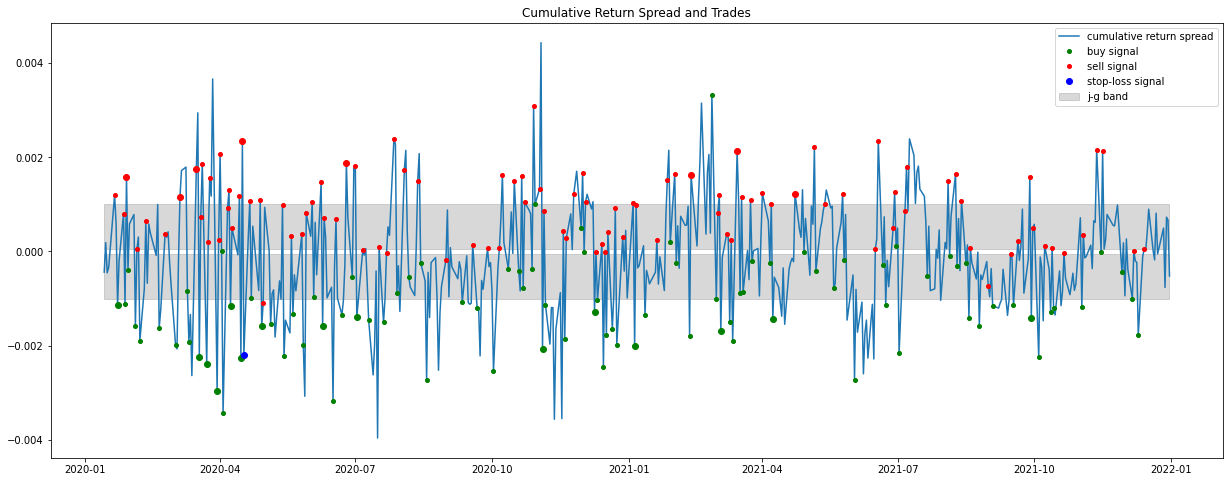

In [8]:
plotTradeSim(summary_test,trade_test)

### 2. Analysis
#### 2-1. Study the performance of your strategy as you vary $j$, $g$, $s$, and $M$. Include plots.

You need not run a fancy nonlinear optimizer, but try to find which parameters work well, and explain how you did it. For one or more of the better settings you find, look into correlations to Fama French factor returns.

**2-1-1. Performance of various combinations of parameters**

The metric for performance would be **cumulative rate of return** over the period.

1. Find good ranges for the parameters to try. (Without worrying about look-ahead bias.)
   1. `j` & `g` -- use "cumulative return spread" (`cumret_spread`) *NOTE: cumulative return may decrease as `M` increases
   2. `s` -- roughly from `-1` to `0`
   3. `M` -- `1`=no rolling, `10`=given in assignment, `20`=roughly the number of trading days in a month, `60` roughly the number of trading days in a quarter (does not make much sense to smooth the spread further)
2. Create the combinations of parameters in the range as found above. (Constraint: `0 =< j < g <= 1`)
3. Run the function `spreadTradeSimulation` on the combinations of parameters.

In [9]:
# 0. Get trade data
secs,start_date,end_date = ("FCOM","VOX"),"2019-12-02","2021-12-31"

# Set M=1 to not smooth the spread, so we can get max range for return spread.
# The rest of the parameters don't matter as they don't affect the spread.
summary_2,trade_2 = spreadTradeSimulation(secs,start_date,end_date,M=1)

trade  | START | K (initial capital)=83685425, M=1, j=0.00050, g=0.00201, s=-0.500.



In [10]:
# 1. Find good ranges for the parameters to try.
jg_max = round(max(abs(trade_2['cumret_spread'].min()),abs(trade_2['cumret_spread'].max())),3)
print('j and g should be between: 0 and {}.'.format(jg_max))


j and g should be between: 0 and 0.005.


In [11]:
#2. Create combinations of parameters in the range as found above.
jg_range = np.arange(0,jg_max,0.0003)

jg_list = [(j,g) for j,g in permutations(jg_range,2) if g-j>=0.0005] # make sure the j-g band is wider than 0.0005

M_list = [1,10,20,60]
s_list = np.arange(-1,-0.2,0.2)

params = []
for jg in jg_list:
    for M in M_list:
        for s in s_list:
            params.append((M,round(jg[0],5),round(jg[1],5),round(s,1)))

print('Generated {} combinations of parameters.'.format(len(params)))

Generated 1920 combinations of parameters.


In [12]:
#3. 

secs,start_date,end_date,N_window = ("FCOM","VOX"),"2019-12-02","2021-12-31",15

PnL_daily_max = []
PnL_cumulative = []
for p in params:
    M,j,g,s = p
    summary,trade = spreadTradeSimulation(secs, start_date, end_date,
                                          N_window=N_window, M=M, 
                                          j=j, g=g, s=s)

    PnL_daily_max.append(summary.loc['PnL_daily_max'].value)
    PnL_cumulative.append(summary.loc['PnL_cumulative'].value)
    

result = pd.DataFrame({'parameters':params,
                       'PnL_daily_max':PnL_daily_max,
                       'PnL_cumulative':PnL_cumulative})


trade  | START | K (initial capital)=83685425, M=1, j=0.00000, g=0.00060, s=-1.000.

trade  | START | K (initial capital)=83685425, M=1, j=0.00000, g=0.00060, s=-0.800.

trade  | START | K (initial capital)=83685425, M=1, j=0.00000, g=0.00060, s=-0.600.

trade  | START | K (initial capital)=83685425, M=1, j=0.00000, g=0.00060, s=-0.400.

trade  | START | K (initial capital)=83685425, M=10, j=0.00000, g=0.00060, s=-1.000.

trade  | START | K (initial capital)=83685425, M=10, j=0.00000, g=0.00060, s=-0.800.

trade  | START | K (initial capital)=83685425, M=10, j=0.00000, g=0.00060, s=-0.600.

trade  | START | K (initial capital)=83685425, M=10, j=0.00000, g=0.00060, s=-0.400.

trade  | START | K (initial capital)=83685425, M=20, j=0.00000, g=0.00060, s=-1.000.

trade  | START | K (initial capital)=83685425, M=20, j=0.00000, g=0.00060, s=-0.800.

trade  | START | K (initial capital)=83685425, M=20, j=0.00000, g=0.00060, s=-0.600.

trade  | START | K (initial capital)=83685425, M=20, j=0.0

**2-1-2. Find "good" settings**

In [13]:
# Rank params based on settings

top10 = result.sort_values('PnL_cumulative',ascending=False).head(10).reset_index(drop=True)
top10

,parameters,PnL_daily_max,PnL_cumulative
0,"(60, 0.0, 0.0015, -0.4)",0.0380,4.5407
1,"(60, 0.0, 0.0012, -0.4)",0.0380,4.4829
2,"(60, 0.0, 0.0009, -0.4)",0.0380,4.4745
3,"(60, 0.0, 0.0006, -0.4)",0.0379,4.3543
4,"(60, 0.0003, 0.0009, -0.4)",0.0380,4.1773
5,"(60, 0.0003, 0.0015, -0.4)",0.0380,4.1717
6,"(60, 0.0003, 0.0012, -0.4)",0.0380,4.1118
7,"(60, 0.0, 0.0018, -0.4)",0.0285,4.0706
8,"(60, 0.0, 0.0024, -0.4)",0.0226,3.9525
9,"(60, 0.0003, 0.0018, -0.4)",0.0285,3.8732


*NOTE: paramters are in order `M`,`j`,`g`,`s`

As we can see, the top 10 performing paramter combinations all have `M=60`, `j` either equal to `0` or `0.0003` -- as close to zero as possible, and `s` approximately equal to `-0.4`.


The reason the M-day return spread rolling window should be 60 may be because a quarter has roughly 60 trading days. Since `FXOM` and `VOX` are both communication services indices which value is dependent on companies that publish quarterly reports. After each reporting period, the spread between the indices may deviate. Another wild guess is that the communication services companies may have a quarterly-cyclical nature, which may also influence the value of the indices. However, more analysis on the firms may be needed to verify this.

Also, it may be that "the smoother the spread curve, the higher the return", and 60 is the highest number we've tried. However, since we only have a 2-year period, it would not make too much sense to have a 1-year rolling window and ending up with a buy-and-hold strategy. Therefore, keeping the 60-day-window is good enough.

**2-1-3. Correlation between the "good setting" and Fama-French returns**

In [14]:
# trade using the "good setting"
top_params1 = top10['parameters'][0] # (60, 0.0, 0.0018, -0.4)
top_params2 = top10['parameters'][1] # (60, 0.0, 0.0024, -0.4)

secs,start_date,end_date,N_window = ("FCOM","VOX"),"2019-12-02","2021-12-31",15
M,j,g,s = top_params1
summary_top1,trade_top1 = spreadTradeSimulation(secs, start_date, end_date,
                                                N_window=N_window, M=M, 
                                                j=j, g=g, s=s)

M,j,g,s = top_params2
summary_top2,trade_top2 = spreadTradeSimulation(secs, start_date, end_date,
                                                N_window=N_window, M=M, 
                                                j=j, g=g, s=s)

trade  | START | K (initial capital)=83685425, M=60, j=0.00000, g=0.00150, s=-0.400.

trade  | START | K (initial capital)=83685425, M=60, j=0.00000, g=0.00120, s=-0.400.



<module 'matplotlib.pyplot' from 'C:\\Users\\ashle\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

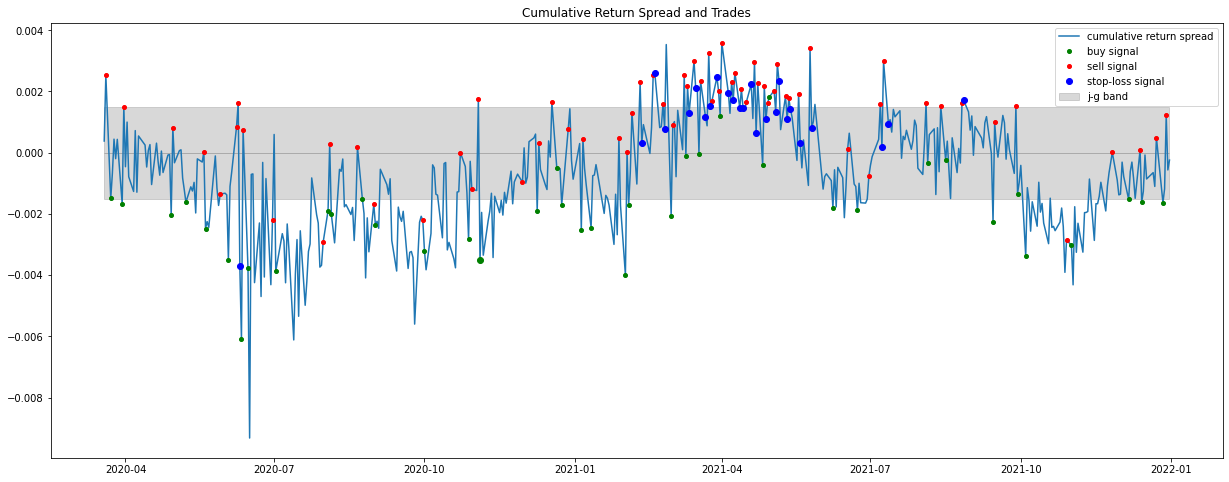

In [15]:
plotTradeSim(summary_top1,trade_top1)

<module 'matplotlib.pyplot' from 'C:\\Users\\ashle\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

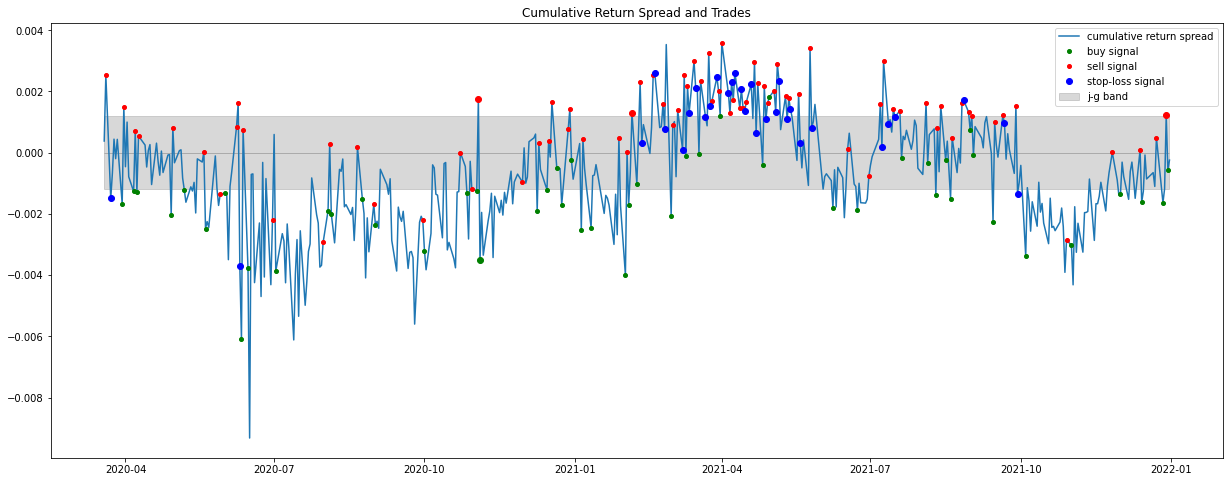

In [16]:
plotTradeSim(summary_top2,trade_top2)

In [21]:
# Correlation with daily FF factor returns

FF = getFFData(start_date,end_date).rolling(60).median() # make the return into the same rolling window as the spread trade

data = pd.concat([FF,trade_top1['PnL_daily']],axis=1).dropna()
data.rename(columns={'PnL_daily':'spread_trade'},inplace=True)
pd.DataFrame(data.corr()['spread_trade'].iloc[:4]) # No need to compare top2 as well since top1 and top2 are very similar.

,spread_trade
Mkt-RF,0.3547
SMB,0.1119
HML,-0.4422
RF,-0.0704


<AxesSubplot:title={'center':'Time Series Daily Returns of Spread Trade and Fama-French Factors'}, xlabel='date'>

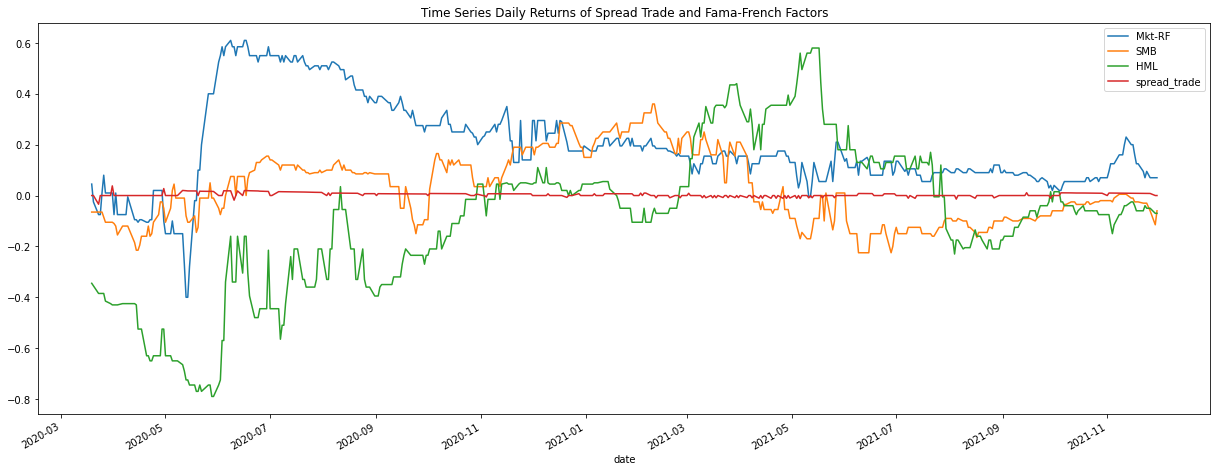

In [22]:
data[['Mkt-RF','SMB','HML','spread_trade']].plot(title='Time Series Daily Returns of Spread Trade and Fama-French Factors')

The PnL of our spread strategy has a very low correlation with the Fama-French factor daily returns. From the graph, we can also see that the variance of the spread trade is a lot lower than the factor model returns. This can be because
1. Our strategy is based on the spread of two indices, rather than the growth of a market factor
2. The indices in the spread trade -- `FCOM` and `VOX` are both communication services indices, which is only a small portion of the market that the Fama French model looks at
3. Our strategy has periods where we do not hold a position, which makes our portfolio value more stable
4. The optimal spread strategy is ran on a smoother returns series with rolling window of 60

This can mean that
1. Using a combination of Fama-French factor portfolios and our spread trade portfolio can introduce good diversification benefits.
2. The spread provides promising returns with lower risk compared to the Fama-French factor returns.

However, we constructed the spread trade portfolio with look-ahead bias, which means that the live returns for this strategy may not be as high as what is back-tested. 